# **LIBRARIES**
---

In [1]:
import sys
import os
os.chdir('..')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# Module
from src.modules.processing import DataLoader, OutlierHandler, Transformation, ImbalanceHandler

In [2]:
data_loader = DataLoader()
bank_data = data_loader.combine_datasets()

# **HANDLING OUTLIERS**
---

In [3]:
# Initialize outlier handler
outlier_handler = OutlierHandler(iqr_multiplier=1.5, target_col='Exited')

# Detect outliers
outlier_handler.detect_outliers(bank_data)
summary_before = outlier_handler.get_outlier_summary()
bounds_before = outlier_handler.outlier_bounds.copy()

In [4]:
summary_before['outlier_percentage'] = (summary_before['outlier_count']/len(bank_data)) * 100

# Rename
summary_before = summary_before.rename(columns={
    "column": "Feature",
    "outlier_count": "Outlier Count",
    "outlier_percentage": "Outlier Percentage",
    "lower_bound": "Lower Bound",
    "upper_bound": "Upper Bound"
}).set_index("Feature")

# Display
display(
    summary_before.style.format({
        "Outlier Percentage": "{:.2f}%",
        "lower_bound": "{:.2f}",
        "upper_bound": "{:.2f}"
    })
)

,Outlier Count,Lower Bound,Upper Bound,iqr_multiplier,Outlier Percentage
Feature,,,,,
CreditScore,331,427.500000,879.500000,1.500000,0.19%
EstimatedSalary,0,-49170.085000,277129.795000,1.500000,0.00%
NumOfProducts,535,-0.500000,3.500000,1.500000,0.31%
Balance,0,-181093.946250,301823.243750,1.500000,0.00%
Age,7049,17.000000,57.000000,1.500000,4.03%
Tenure,0,-3.000000,13.000000,1.500000,0.00%


In [5]:
# Remove Outliers
bank_clean = outlier_handler.remove_outliers(bank_data, strategy='any', max_iter=10)

Iteration 1: 7915 outliers
Iteration 2: 3408 outliers
Iteration 3: 0 outliers


In [6]:
outlier_handler.detect_outliers(bank_clean)
summary_after = outlier_handler.get_outlier_summary()
bounds_after = outlier_handler.outlier_bounds.copy()

In [7]:
summary_after['outlier_percentage'] = (summary_after['outlier_count']/len(bank_clean)) * 100

# Rename
summary_after = summary_after.rename(columns={
    "column": "Feature",
    "outlier_count": "Outlier Count",
    "outlier_percentage": "Outlier Percentage",
    "lower_bound": "Lower Bound",
    "upper_bound": "Upper Bound"
}).set_index("Feature")

# Display
display(
    summary_after.style.format({
        "Outlier Percentage": "{:.2f}%",
        "lower_bound": "{:.2f}",
        "upper_bound": "{:.2f}"
    })
)

,Outlier Count,Lower Bound,Upper Bound,iqr_multiplier,Outlier Percentage
Feature,,,,,
CreditScore,0,426.000000,882.000000,1.500000,0.00%
EstimatedSalary,0,-48149.335000,276702.065000,1.500000,0.00%
NumOfProducts,0,-0.500000,3.500000,1.500000,0.00%
Balance,0,-180378.030000,300630.050000,1.500000,0.00%
Age,0,18.500000,54.500000,1.500000,0.00%
Tenure,0,-3.000000,13.000000,1.500000,0.00%


In [8]:
cols_with_outliers = summary_before[
    summary_before["Outlier Count"] > 0
].index.tolist()

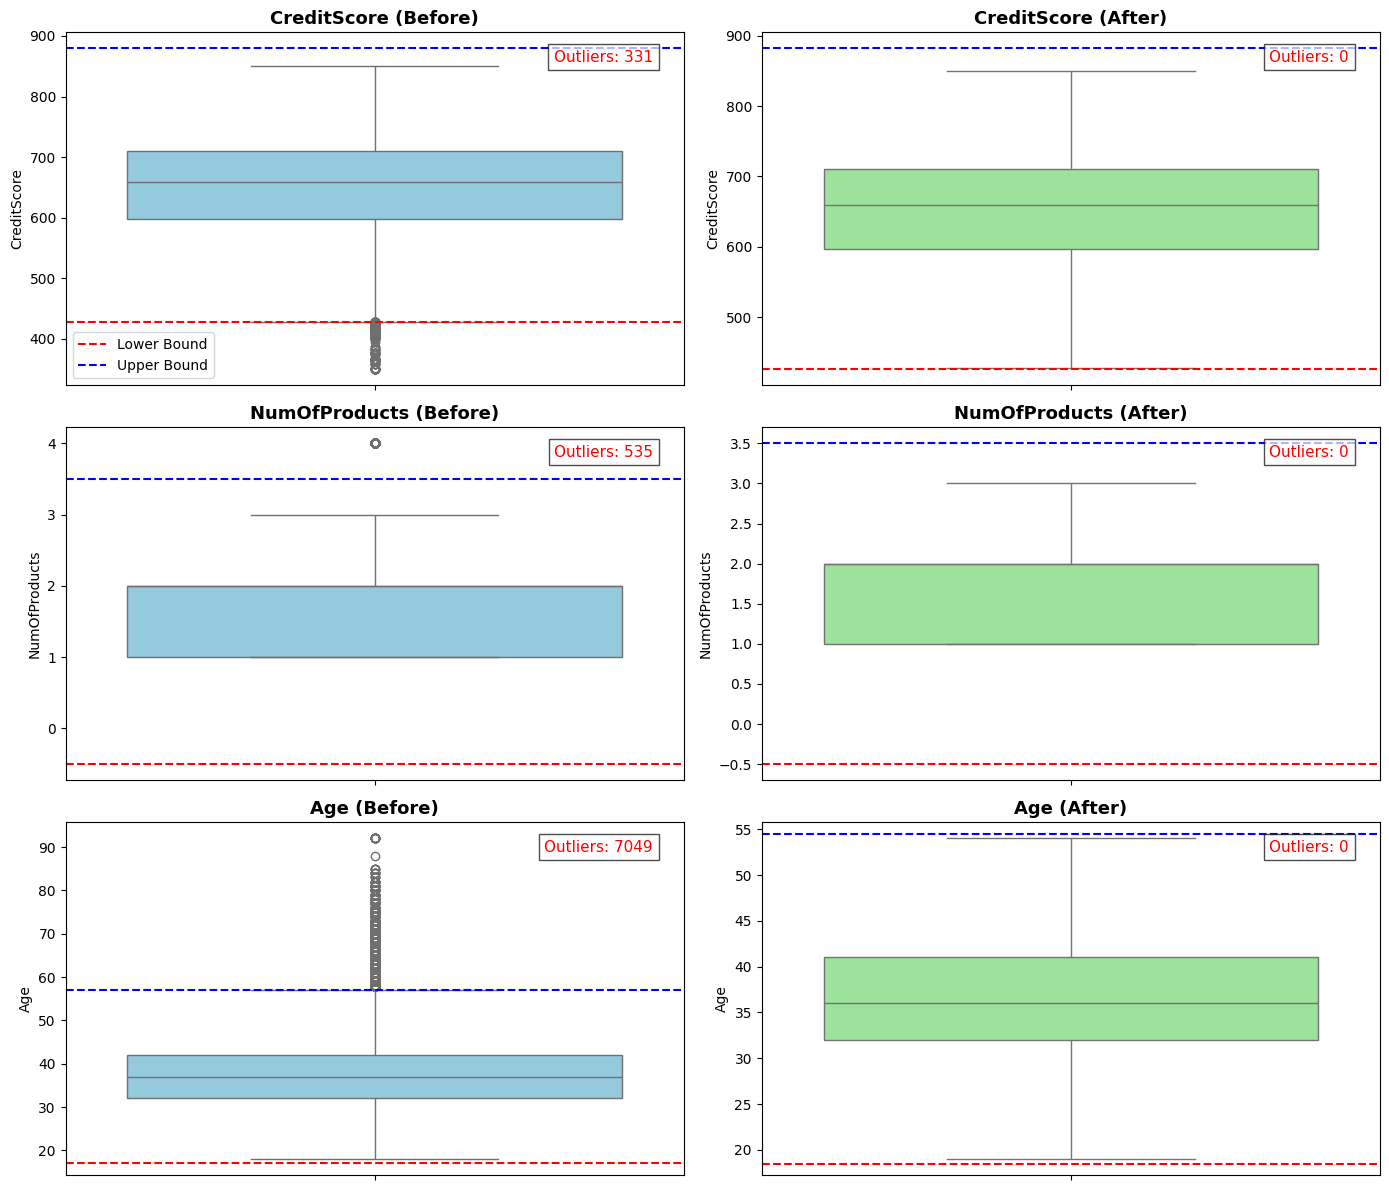

In [9]:
# BOXPLOT
n_cols = 2
n_rows = len(cols_with_outliers)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(cols_with_outliers):
    # -------- BEFORE --------
    ax = axes[i*2]
    sns.boxplot(y=bank_data[col], ax=ax, color="skyblue")

    ax.axhline(bounds_before[col]['lower'], color='red', linestyle='--', label='Lower Bound')
    ax.axhline(bounds_before[col]['upper'], color='blue', linestyle='--', label='Upper Bound')

    ax.set_title(f"{col} (Before)", fontsize=13, fontweight="bold")
    ax.text(0.95, 0.95, 
            f'Outliers: {summary_before.loc[col, "Outlier Count"]}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, fontsize=11, color='red',
            bbox=dict(facecolor='white', alpha=0.7))
    if i == 0:
        ax.legend(fontsize=10)

    # -------- AFTER --------
    ax = axes[i*2+1]
    sns.boxplot(y=bank_clean[col], ax=ax, color="lightgreen")

    ax.axhline(bounds_after[col]['lower'], color='red', linestyle='--')
    ax.axhline(bounds_after[col]['upper'], color='blue', linestyle='--')

    ax.set_title(f"{col} (After)", fontsize=13, fontweight="bold")
    ax.text(0.95, 0.95, 
            f'Outliers: {summary_after.loc[col, "Outlier Count"]}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, fontsize=11, color='red',
            bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()


# **TRANSFORMATION**
---

In [10]:
transformer = Transformation(handle_categorical=True)
bank_scaled = transformer.fit_transform(bank_clean)

In [11]:
display(bank_scaled.head())

,CreditScore,Exited,EstimatedSalary,IsActiveMember,NumOfProducts,Balance,HasCrCard,Age,Tenure,Gender_Male
0,-0.472506,1,-0.294455,1.0,-1.042325,0.000000,1.0,0.775641,-1.2,0.0
1,-0.608978,0,-0.099560,1.0,-1.042325,0.574618,-1.0,0.639778,-1.6,0.0
2,-1.915230,1,-0.073034,0.0,2.734123,0.969471,1.0,0.775641,1.2,0.0
3,0.524702,0,-0.434059,0.0,0.845899,0.000000,-1.0,0.363522,-1.6,0.0
4,2.427102,0,-0.775692,1.0,-1.042325,0.800772,1.0,0.910060,-1.2,0.0


In [13]:
display(bank_scaled.describe().T)

,count,mean,std,min,25%,50%,75%,max
CreditScore,163775.0,8.191144e-17,1.000003,-2.816521,-0.745286,0.025093,0.674961,2.427102
Exited,163775.0,1.938269e-01,0.395296,0.000000,0.000000,0.000000,0.000000,1.000000
EstimatedSalary,163775.0,4.046981e-16,1.000003,-1.739571,-0.863985,-0.014863,0.863882,1.736361
IsActiveMember,163775.0,4.897878e-01,0.499897,0.000000,0.000000,0.000000,1.000000,1.000000
NumOfProducts,163775.0,1.263380e-16,1.000003,-1.042325,-1.042325,0.845899,0.845899,2.734123
Balance,163775.0,3.562446e-01,0.394531,0.000000,0.000000,0.000000,0.750981,1.000000
HasCrCard,163775.0,5.046375e-01,0.863334,-1.000000,1.000000,1.000000,1.000000,1.000000
Age,163775.0,-3.422232e-16,1.000003,-2.866235,-0.657354,-0.063047,0.639778,2.305446
Tenure,163775.0,9.950237e-03,1.123272,-2.000000,-0.800000,0.000000,0.800000,2.000000
Gender_Male,163775.0,5.674309e-01,0.495434,0.000000,0.000000,1.000000,1.000000,1.000000


# **DATA BALANCING**
---

# **MODEL TEST**
---

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [19]:
# --- 1. Original features (before scaling) ---
X_orig = bank_clean.drop(columns=['Exited'], errors='ignore')
y = bank_clean['Exited']

In [22]:
# --- 2. Split train/validation ---
X_orig_encoded = pd.get_dummies(X_orig, drop_first=True)

X_train_o, X_val_o, y_train, y_val = train_test_split(
    X_orig_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
# --- 3. Train Gradient Boosting on original data ---
model_orig = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_orig.fit(X_train_o, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [25]:
# --- 5. Transformed features (after scaling + encoding) ---
transformer = Transformation(handle_categorical=True)
X_scaled = transformer.fit_transform(bank_clean.drop(columns=['Exited'], errors='ignore'))


In [26]:
# --- 6. Split train/validation on scaled data ---
X_train_s, X_val_s, _, _ = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
# --- 7. Train Gradient Boosting on scaled data ---
model_scaled = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_scaled.fit(X_train_s, y_train)


,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [24]:
# --- 4. Evaluate original ---
y_pred_o = model_orig.predict(X_val_o)
y_proba_o = model_orig.predict_proba(X_val_o)[:,1]
print("=== Original Data ===")
print(classification_report(y_val, y_pred_o))
print("ROC AUC:", roc_auc_score(y_val, y_proba_o))

=== Original Data ===
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     26406
           1       0.73      0.47      0.57      6349

    accuracy                           0.86     32755
   macro avg       0.80      0.71      0.74     32755
weighted avg       0.85      0.86      0.85     32755

ROC AUC: 0.8747346477751665


In [28]:
# --- 8. Evaluate scaled ---
y_pred_s = model_scaled.predict(X_val_s)
y_proba_s = model_scaled.predict_proba(X_val_s)[:,1]
print("\n=== Scaled / Transformed Data ===")
print(classification_report(y_val, y_pred_s))
print("ROC AUC:", roc_auc_score(y_val, y_proba_s))


=== Scaled / Transformed Data ===
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     26406
           1       0.73      0.47      0.57      6349

    accuracy                           0.86     32755
   macro avg       0.80      0.71      0.74     32755
weighted avg       0.85      0.86      0.85     32755

ROC AUC: 0.8747340930536616
